<!--Copyright © ZOMI 适用于[License](https://github.com/Infrasys-AI/AIInfra)版权许可-->

# CODE 01: 经典 InstructGPT 复现

> Author by: 张玉霖

本实验将使用简化代码复现 InstructGPT 的核心训练流程：监督微调(SFT)→奖励模型训练(RM)→PPO 强化学习优化。通过这个实验，我们可以深入理解如何通过人类反馈强化学习将人类偏好传递给语言模型。

实验以 **教学用最小实现（toy）** 的方式演示 InstructGPT 的训练三阶段：**监督微调 (SFT)** → **奖励模型 (RM)** → **PPO 强化学习**。我们不追求大模型效果，而是聚焦**关键接口与损失函数**，用小数据集展示 RLHF 的核心思路：**先通过 SFT 学会跟随指令，再用奖励模型评分，最后用 PPO 让策略在不偏离过远的前提下朝更高奖励更新**。


## 1. 环境设置

首先安装必要的依赖库：

In [ ]:
%pip install torch numpy tqdm matplotlib

现在导入实验所需的模块：

In [1]:
import math
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## 2. Stage1：监督微调 SFT

监督微调阶段使用人类标注的指令-回答对来微调预训练语言模型，使其初步学会遵循指令。

在 SFT 阶段，我们使用标准的监督学习方式，使用人类标注的高质量问答对数据来微调预训练语言模型。模型的训练目标是最大化在给定指令情况下，生成人类期望回答的似然概率。

数学上，这个目标可以表示为：

$$ \mathcal{L}_{SFT} = -\mathbb{E}_{(x,y)\sim D}[\log P_{\theta}(y|x)] $$

其中 $x$ 是指令，$y$ 是人类标注的回答，$\theta$ 是模型参数。

### 2.1 数据准备

我们创建一个简化的指令-回答数据集，并实现一个简单的文本编码器：

In [2]:
class SimpleTokenizer:
    """字节级分词器，用于将文本转换为模型可处理的 token 序列。
    
    该分词器将文本编码为 UTF-8 字节序列，并使用特殊标记组织输入格式。
    支持中文、英文等各种字符，采用[BOS]指令[SEP]回答[EOS][PAD...]模板结构。
    
    Attributes:
        PAD (int): 填充标记 ID，值为 0
        BOS (int): 开始标记 ID，值为 1
        SEP (int): 分隔符标记 ID，值为 2
        EOS (int): 结束标记 ID，值为 3
        max_len (int): 最大序列长度
        vocab_size (int): 词汇表大小（256 个 UTF-8 字节 + 4 个特殊标记）
    """
    PAD, BOS, SEP, EOS = 0, 1, 2, 3  # 特殊符号固定 0~3

    def __init__(self, max_len: int = 128):
        """初始化 ByteTokenizer。
        
        Args:
            max_len (int): 序列最大长度，默认为 128
        """
        self.max_len = max_len
        self.vocab_size = 256 + 4

    def _to_bytes(self, text: str):
        """将文本转换为 UTF-8 字节序列。
        
        Args:
            text (str): 输入文本
            
        Returns:
            list: UTF-8 字节值列表
        """
        return list(text.encode("utf-8", errors="replace"))

    def encode_dialog(self, instr: str, resp: str):
        """将指令-回答对话编码为模型输入格式。
        
        使用[BOS]指令[SEP]回答[EOS][PAD...]模板编码对话，
        并生成相应的注意力掩码和训练标签。
        
        Args:
            instr (str): 指令文本
            resp (str): 回答文本
            
        Returns:
            dict: 包含以下键值的字典：
                - input_ids (torch.Tensor): 输入 token ID 序列，形状[T]
                - attention_mask (torch.Tensor): 注意力掩码，形状[T]
                - labels (torch.Tensor): 训练标签，形状[T]，非回答段为-100
        """
        # 将指令和回答文本转换为字节序列
        instr_bytes = self._to_bytes(f"Instruct:{instr}")

        # 将 Answer:前缀去掉，只保留纯回答内容
        # 因为根据实验发现，加上 Answer:前缀会导致模型生成时重复输出 Answer
        # resp_bytes  = self._to_bytes(f"Answer:{resp}")
        resp_bytes  = self._to_bytes(f"{resp}")

        # 构建完整的 token ID 序列
        ids = [self.BOS]    # 开始标记
        # 指令部分：每个字节偏移+4 以避开特殊符号
        ids += [b + 4 for b in instr_bytes]
        ids += [self.SEP]   # 分隔符，用于分隔指令和回答
        # 回答部分：每个字节偏移+4 以避开特殊符号
        ids += [b + 4 for b in resp_bytes]
        ids += [self.EOS]   # 结束标记

        # 截断处理：如果序列超过最大长度，保留 EOS 在末端
        if len(ids) > self.max_len:
            ids = ids[: self.max_len - 1] + [self.EOS]

        # 构建注意力掩码：有效位置为 1，填充位置为 0
        attn = [1] * len(ids)

        # 填充处理：如果序列长度不足最大长度，用 PAD 填充
        if len(ids) < self.max_len:
            pad = self.max_len - len(ids)
            ids += [self.PAD] * pad
            attn += [0] * pad
        
        input_ids = torch.tensor(ids, dtype=torch.long)
        attention_mask = torch.tensor(attn, dtype=torch.long)

        # 构建语言模型训练标签（左移一位）
        labels = input_ids.clone()
        labels[:-1] = input_ids[1:]
        labels[-1] = self.EOS

        # 找到 SEP 标记的位置，用于确定回答的开始位置
        sep_positions = (input_ids == self.SEP).nonzero(as_tuple=True)[0]
        sep_idx = int(sep_positions[0].item()) if len(sep_positions) > 0 else 0

        # 屏蔽不需要计算损失的位置：
        # 1. 指令段和 SEP 标记之前的部分设置为-100
        labels[: sep_idx + 1] = -100               
        # 2. PAD 填充部分设置为-100
        labels[input_ids == self.PAD] = -100       

        return {
            "input_ids": input_ids,           
            "attention_mask": attention_mask, 
            "labels": labels,                 
        }


In [3]:
## 测试编码的效果
tok = SimpleTokenizer(max_len=128)
pack = tok.encode_dialog("What is machine learning?", "Machine learning is technology that enables computers to learn from data.")
pack, pack["input_ids"].shape, pack["attention_mask"].shape, pack["labels"].shape

({'input_ids': tensor([  1,  77, 114, 119, 120, 118, 121, 103, 120,  62,  91, 108, 101, 120,
           36, 109, 119,  36, 113, 101, 103, 108, 109, 114, 105,  36, 112, 105,
          101, 118, 114, 109, 114, 107,  67,   2,  81, 101, 103, 108, 109, 114,
          105,  36, 112, 105, 101, 118, 114, 109, 114, 107,  36, 109, 119,  36,
          120, 105, 103, 108, 114, 115, 112, 115, 107, 125,  36, 120, 108, 101,
          120,  36, 105, 114, 101, 102, 112, 105, 119,  36, 103, 115, 113, 116,
          121, 120, 105, 118, 119,  36, 120, 115,  36, 112, 105, 101, 118, 114,
           36, 106, 118, 115, 113,  36, 104, 101, 120, 101,  50,   3,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0]),
  'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [4]:
# SFT Dataset & DataLoader
class SFTDataset(Dataset):
    def __init__(self, pairs, tokenizer: SimpleTokenizer):
        self.pairs = pairs
        self.tok = tokenizer

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        instr, resp = self.pairs[idx]
        return self.tok.encode_dialog(instr, resp)

def build_sft_dataloader(pairs, tokenizer: SimpleTokenizer, batch_size=4, shuffle=True):
    ds = SFTDataset(pairs, tokenizer)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

# def create_sft_dataset():
#     return [
#         ("什么是 AI？", "AI 是能模拟人类智能的技术。"),
#         ("1+1 等于几？", "1+1 等于 2。"),
#         ("写一句问候语", "你好，很高兴见到你！"),
#         ("什么是机器学习？", "机器学习是让计算机从数据中学习的技术。"),
#         ("如何保护环境？", "减少浪费，节约能源，绿色出行。"),
#     ]
def create_sft_dataset():
    return [
        ("What is AI?", "AI is technology that can simulate human intelligence."),
        ("What is 1+1?", "1+1 equals 2."),
        ("Write a greeting", "Hello, nice to meet you!"),
        ("What is machine learning?", "Machine learning is technology that enables computers to learn from data."),
        ("How to protect the environment?", "Reduce waste, save energy, and travel green.")
    ]

# 初始化 SFT 数据
tokenizer = SimpleTokenizer(max_len=128)
pairs = create_sft_dataset()
sft_loader = build_sft_dataloader(pairs, tokenizer, batch_size=2, shuffle=True)

len(pairs), tokenizer.vocab_size


(5, 260)

这里创建了一个简单的字节级分词器`SimpleTokenizer`，将文本编码为 UTF-8 字节并使用 [BOS]…[SEP]…[EOS] 模板；SFTDataset 仅在回答区间计算交叉熵，这是条件语言建模的标准做法。

### 2.2 模型定义

定义一个简化的 Transformer 模型，包含必要的位置编码：

In [5]:
class SimpleTransformerLM(nn.Module):
    """Decoder-only（用 TransformerEncoder + 因果掩码模拟）语言模型。"""
    def __init__(self, vocab_size, max_len=128, d_model=128, nhead=4, num_layers=4,
                 dropout=0.1, tie_weights=True, pad_id=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.d_model = d_model

        # 指定 padding_idx，避免 PAD embedding 被更新
        self.embed = nn.Embedding(vocab_size, d_model, padding_idx=pad_id)
        self.pos_embed = nn.Embedding(max_len, d_model)

        layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(layer, num_layers=num_layers)

        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)
        if tie_weights:
            self.lm_head.weight = self.embed.weight

        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(d_model)

        # 因果掩码：上三角 True 表示被遮蔽（看不到未来）
        self.register_buffer(
            "causal_mask",
            torch.triu(torch.ones(max_len, max_len), diagonal=1).bool()
        )

        nn.init.normal_(self.embed.weight, std=0.02)
        nn.init.normal_(self.pos_embed.weight, std=0.02)
        if not tie_weights:
            nn.init.normal_(self.lm_head.weight, std=0.02)

    def forward(self, input_ids, attention_mask=None):
        B, T = input_ids.shape
        if T > self.max_len:
            raise ValueError(f"seq_len {T} > max_len {self.max_len}")

        tok = self.embed(input_ids) * math.sqrt(self.d_model)
        pos_ids = torch.arange(T, device=input_ids.device, dtype=torch.long)\
                       .unsqueeze(0).expand(B, T)
        pos = self.pos_embed(pos_ids)
        x = self.ln(self.dropout(tok + pos))

        cmask = self.causal_mask[:T, :T]  # [T,T] True=mask
        kpmask = (~attention_mask.bool()) if attention_mask is not None else None  # [B,T] True=pad

        h = self.transformer(x, mask=cmask, src_key_padding_mask=kpmask)  # [B,T,H]
        logits = self.lm_head(h)  # [B,T,V]
        return logits


简化 Transformer 模型包含嵌入层、位置编码和 Transformer 编码器。我们使用了正弦/余弦位置编码，位置编码让模型能够理解文本中的顺序信息，是 Transformer 架构的关键组件。

### 2.3 SFT 训练

In [12]:
model = SimpleTransformerLM(
    vocab_size=tokenizer.vocab_size,
    max_len=128,
    d_model=128,
    nhead=4,
    num_layers=4,
    dropout=0.1,
    tie_weights=True,
    pad_id=tokenizer.PAD,   
).to(device)

sft_criterion = nn.CrossEntropyLoss(ignore_index=-100)  # 只在回答段计算
sft_optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_sft(model, dataloader, epochs=30, grad_clip=1.0):
    model.train()
    losses = []
    for ep in range(epochs):
        ep_loss = 0.0
        pbar = tqdm(dataloader, desc=f"[SFT] Epoch {ep+1}/{epochs}")
        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attn_mask = batch["attention_mask"].to(device)
            labels    = batch["labels"].to(device)

            sft_optimizer.zero_grad()
            logits = model(input_ids, attention_mask=attn_mask)  # [B,T,V]
            loss = sft_criterion(
                logits.view(-1, model.vocab_size),
                labels.view(-1)
            )
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            sft_optimizer.step()

            ep_loss += float(loss.item())
            pbar.set_postfix(loss=float(loss.item()))
        avg = ep_loss / max(1, len(dataloader))
        losses.append(avg)
        print(f"[SFT] Epoch {ep+1} 平均损失: {avg:.4f}")
    return losses

print("开始 SFT 训练阶段…")
sft_losses = train_sft(model, sft_loader, epochs=30)


开始 SFT 训练阶段…


[SFT] Epoch 1/30: 100%|██████████| 3/3 [00:00<00:00, 56.04it/s, loss=5.18]


[SFT] Epoch 1 平均损失: 5.2533


[SFT] Epoch 2/30: 100%|██████████| 3/3 [00:00<00:00, 54.54it/s, loss=4.47]


[SFT] Epoch 2 平均损失: 4.5989


[SFT] Epoch 3/30: 100%|██████████| 3/3 [00:00<00:00, 55.91it/s, loss=4.05]


[SFT] Epoch 3 平均损失: 4.2027


[SFT] Epoch 4/30: 100%|██████████| 3/3 [00:00<00:00, 65.22it/s, loss=3.69]


[SFT] Epoch 4 平均损失: 3.8092


[SFT] Epoch 5/30: 100%|██████████| 3/3 [00:00<00:00, 65.22it/s, loss=3.43]


[SFT] Epoch 5 平均损失: 3.5364


[SFT] Epoch 6/30: 100%|██████████| 3/3 [00:00<00:00, 65.22it/s, loss=3.23]


[SFT] Epoch 6 平均损失: 3.3203


[SFT] Epoch 7/30: 100%|██████████| 3/3 [00:00<00:00, 64.49it/s, loss=3.21]


[SFT] Epoch 7 平均损失: 3.2076


[SFT] Epoch 8/30: 100%|██████████| 3/3 [00:00<00:00, 107.14it/s, loss=3.59]


[SFT] Epoch 8 平均损失: 3.2397


[SFT] Epoch 9/30: 100%|██████████| 3/3 [00:00<00:00, 107.14it/s, loss=2.87]


[SFT] Epoch 9 平均损失: 3.0166


[SFT] Epoch 10/30: 100%|██████████| 3/3 [00:00<00:00, 111.11it/s, loss=2.74]


[SFT] Epoch 10 平均损失: 2.8621


[SFT] Epoch 11/30: 100%|██████████| 3/3 [00:00<00:00, 100.01it/s, loss=2.61]


[SFT] Epoch 11 平均损失: 2.7614


[SFT] Epoch 12/30: 100%|██████████| 3/3 [00:00<00:00, 93.75it/s, loss=2.72]


[SFT] Epoch 12 平均损失: 2.6557


[SFT] Epoch 13/30: 100%|██████████| 3/3 [00:00<00:00, 93.75it/s, loss=2.77]


[SFT] Epoch 13 平均损失: 2.6135


[SFT] Epoch 14/30: 100%|██████████| 3/3 [00:00<00:00, 96.78it/s, loss=2.34]


[SFT] Epoch 14 平均损失: 2.4779


[SFT] Epoch 15/30: 100%|██████████| 3/3 [00:00<00:00, 96.77it/s, loss=2.4]


[SFT] Epoch 15 平均损失: 2.4282


[SFT] Epoch 16/30: 100%|██████████| 3/3 [00:00<00:00, 95.08it/s, loss=2.34]


[SFT] Epoch 16 平均损失: 2.3240


[SFT] Epoch 17/30: 100%|██████████| 3/3 [00:00<00:00, 86.75it/s, loss=2.18]


[SFT] Epoch 17 平均损失: 2.2388


[SFT] Epoch 18/30: 100%|██████████| 3/3 [00:00<00:00, 76.92it/s, loss=2.13]


[SFT] Epoch 18 平均损失: 2.1665


[SFT] Epoch 19/30: 100%|██████████| 3/3 [00:00<00:00, 107.14it/s, loss=1.91]


[SFT] Epoch 19 平均损失: 2.0518


[SFT] Epoch 20/30: 100%|██████████| 3/3 [00:00<00:00, 100.00it/s, loss=2.19]


[SFT] Epoch 20 平均损失: 2.0638


[SFT] Epoch 21/30: 100%|██████████| 3/3 [00:00<00:00, 103.44it/s, loss=1.61]


[SFT] Epoch 21 平均损失: 1.8580


[SFT] Epoch 22/30: 100%|██████████| 3/3 [00:00<00:00, 100.00it/s, loss=1.95]


[SFT] Epoch 22 平均损失: 1.8680


[SFT] Epoch 23/30: 100%|██████████| 3/3 [00:00<00:00, 103.44it/s, loss=1.97]


[SFT] Epoch 23 平均损失: 1.7941


[SFT] Epoch 24/30: 100%|██████████| 3/3 [00:00<00:00, 100.00it/s, loss=1.83]


[SFT] Epoch 24 平均损失: 1.7444


[SFT] Epoch 25/30: 100%|██████████| 3/3 [00:00<00:00, 103.44it/s, loss=1.75]


[SFT] Epoch 25 平均损失: 1.6805


[SFT] Epoch 26/30: 100%|██████████| 3/3 [00:00<00:00, 93.75it/s, loss=1.67]


[SFT] Epoch 26 平均损失: 1.6553


[SFT] Epoch 27/30: 100%|██████████| 3/3 [00:00<00:00, 93.75it/s, loss=1.03]


[SFT] Epoch 27 平均损失: 1.4357


[SFT] Epoch 28/30: 100%|██████████| 3/3 [00:00<00:00, 85.71it/s, loss=1.89]


[SFT] Epoch 28 平均损失: 1.6636


[SFT] Epoch 29/30: 100%|██████████| 3/3 [00:00<00:00, 100.01it/s, loss=1.32]


[SFT] Epoch 29 平均损失: 1.4517


[SFT] Epoch 30/30: 100%|██████████| 3/3 [00:00<00:00, 100.00it/s, loss=1.58]

[SFT] Epoch 30 平均损失: 1.5323


In [13]:
# 生成函数（贪心/采样简化版）
@torch.no_grad()
def generate_text(model, tokenizer, prompt: str, max_new_tokens=32):
    pack = tokenizer.encode_dialog(prompt, "")
    input_ids = pack["input_ids"].unsqueeze(0).to(device)
    attn_mask = pack["attention_mask"].unsqueeze(0).to(device)

    # 去掉右侧 PAD
    true_len = int(attn_mask.sum(dim=1).item())
    input_ids = input_ids[:, :true_len]
    attn_mask = attn_mask[:, :true_len]

    for i in range(max_new_tokens):
        logits = model(input_ids, attention_mask=attn_mask)
        next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)

        # import matplotlib.pyplot as plt
        # # 将 logits 转换到 cpu 并转为 numpy 数组
        # last_logits = logits[0, -1, :].cpu().numpy()
        # plt.figure(figsize=(12, 4))
        # plt.plot(last_logits)
        # plt.title(f"Logits Distribution for Token {i+1}")
        # plt.xlabel("Token ID")
        # plt.ylabel("Logit Value")
        # # 标记出最大值的位置
        # max_logit_idx = last_logits.argmax()
        # max_logit_val = last_logits[max_logit_idx]
        # plt.scatter(max_logit_idx, max_logit_val, color='red', zorder=5, label=f'Max Logit at ID {max_logit_idx}')
        # plt.legend()
        # plt.grid(True)
        # plt.show()
        # # --- 可视化结束 ---

        input_ids = torch.cat([input_ids, next_token], dim=1)
        attn_mask = torch.cat([attn_mask, torch.ones_like(next_token)], dim=1)
        if next_token.item() == tokenizer.EOS:
            break

    # decode：去掉 BOS/SEP/EOS，只取回答区间
    ids = input_ids[0].tolist()
    if tokenizer.SEP in ids:
        sep_idx = ids.index(tokenizer.SEP)
        ans_ids = ids[sep_idx+1:]
    else:
        ans_ids = ids
    # 去掉 PAD 和 EOS
    ans_ids = [i for i in ans_ids if i not in (tokenizer.PAD, tokenizer.EOS)]
    # 减 4 还原字节
    text = bytes([i-4 for i in ans_ids]).decode("utf-8", errors="ignore")
    return text


In [14]:
# 根据可视化发现，模型会先输出 0（也就是 PAD），然后输出其他
# 模型效果
test_prompts = [
    "What is AI?",
    "What is 1+1?",
    "Write a greeting",
    "What is machine learning?",
    "Write a greeting"
]

print("=== SFT 模型回答 ===")
for p in test_prompts:
    ans = generate_text(model, tokenizer, p)
    print(f"Q: {p}\nA: {ans}\n")

=== SFT 模型回答 ===
Q: What is AI?
A: lo tellllololinin te t tolat t 

Q: What is 1+1?
A: als e e e e e e e e e te e e 

Q: Write a greeting
A: lllo te te t te t togy te te 

Q: What is machine learning?
A: le e e  e

Q: Write a greeting
A: lllo toll to tett toutt t t tte



In [15]:
# 查看 "Answer:" 对应的编码
text = "Answer:"
list(text.encode("utf-8", errors="replace"))

[65, 110, 115, 119, 101, 114, 58]

训练过程中，我们使用交叉熵损失，让模型学会在给定指令条件下预测下一个 token。
在数据构造时，非回答区间与 PAD 的标签被设为 -100，配合 ignore_index=-100 只在回答区间计算损失；同时 attention_mask 让注意力忽略 PAD 位。随着训练进行，损失应逐步下降，表明模型正在学习指令→回答的条件生成关系。

## 3. Stage2：奖励模型 RM

奖励模型用于学习人类对模型回答的偏好，为强化学习阶段提供奖励信号。

奖励模型的目标是学习人类的偏好判断，即对于同一个指令的多个回答，哪个回答更符合人类偏好。训练数据由人类标注员对模型生成回答的质量进行排名。

奖励模型的训练通常使用对比学习框架，通过比较不同回答的相对质量来学习一个标量奖励函数。常用的损失函数是 pairwise ranking loss：

$$
\mathcal{L}_{RM} = -\mathbb{E}_{(x,y_w,y_l)\sim D}[\log(\sigma(r_{\phi}(x,y_w) - r_{\phi}(x,y_l)))]
$$

其中 $y_w$ 是偏好的回答，$y_l$ 是不偏好的回答，$r_{\phi}$ 是奖励模型。

### 3.1 数据准备

In [16]:
# Cell 2.1 — RM 数据集（pairwise）
class RMDataset(Dataset):
    def __init__(self, data, tokenizer: SimpleTokenizer):
        self.data = data
        self.tok = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        good_pack = self.tok.encode_dialog(item["instr"], item["good"])
        bad_pack  = self.tok.encode_dialog(item["instr"], item["bad"])
        return {
            "good_input_ids": good_pack["input_ids"],
            "good_attention_mask": good_pack["attention_mask"],
            "bad_input_ids": bad_pack["input_ids"],
            "bad_attention_mask": bad_pack["attention_mask"],
        }

def create_rm_dataset():
    # return [
    #     {"instr": "什么是 AI？",
    #      "good": "AI 是能模拟人类智能的技术，比如语音识别和图像识别。",
    #      "bad":  "AI 就是机器人。"},
    #     {"instr": "1+1 等于几？",
    #      "good": "1+1 的结果是 2。",
    #      "bad":  "1+1 可能等于 3，看情况。"},
    #     {"instr": "写一句问候语",
    #      "good": "你好！很高兴有机会与你交流。",
    #      "bad":  "喂，你好。"},
    #     {"instr": "什么是机器学习？",
    #      "good": "机器学习是人工智能的一个分支，让计算机能从数据中学习并改进。",
    #      "bad":  "机器学习就是教机器读书。"},
    # ]
    return [
        {"instr": "What is AI?",
         "good": "AI is technology that can simulate human intelligence, such as speech recognition and image recognition.",
         "bad":  "AI is just robots."},
        {"instr": "What is 1+1?",
         "good": "The result of 1+1 is 2.",
         "bad":  "1+1 might equal 3, depending on the situation."},
        {"instr": "Write a greeting",
         "good": "Hello! I'm glad to have the opportunity to communicate with you.",
         "bad":  "Hey, hello."},
        {"instr": "What is machine learning?",
         "good": "Machine learning is a branch of artificial intelligence that enables computers to learn and improve from data.",
         "bad":  "Machine learning is teaching machines to read."},
    ]

rm_data = create_rm_dataset()
rm_loader = DataLoader(RMDataset(rm_data, tokenizer), batch_size=4, shuffle=True)
len(rm_data)


4

奖励模型需要成对的偏好数据，每个数据点包含一个指令、一个高质量回答和一个低质量回答。这种数据结构允许我们训练模型区分回答的质量差异。

### 3.2 奖励模型

In [17]:
# 奖励模型（与 SFT 同构 backbone，只在回答区间池化）
class RewardModel(nn.Module):
    def __init__(self, backbone_cfg, sep_token_id: int):
        super().__init__()
        self.sep_id = sep_token_id
        self.backbone = SimpleTransformerLM(**backbone_cfg)  # 复用结构，不用 lm_head
        self.reward_head = nn.Linear(self.backbone.d_model, 1)

    @torch.no_grad()
    def load_backbone_from_sft(self, sft_state_dict):
        # 只加载非 lm_head 参数
        state = {k: v for k, v in sft_state_dict.items() if not k.startswith("lm_head.")}
        missing, unexpected = self.backbone.load_state_dict(state, strict=False)
        return missing, unexpected

    def forward(self, input_ids, attention_mask):
        B, T = input_ids.shape

        # 取得 backbone 隐状态（与 LM 的前向一致，但这里我们只要隐藏层，不需要 logits）
        tok = self.backbone.embed(input_ids) * math.sqrt(self.backbone.d_model)
        pos_ids = torch.arange(T, device=input_ids.device).unsqueeze(0).expand(B, T)
        pos = self.backbone.pos_embed(pos_ids)
        x = self.backbone.ln(self.backbone.dropout(tok + pos))
        h = self.backbone.transformer(
            x,
            mask=self.backbone.causal_mask[:T,:T],
            src_key_padding_mask=(~attention_mask.bool())
        )  # [B,T,H]

        # 仅在回答区间池化：pos > SEP 且有效
        is_sep = (input_ids == self.sep_id)
        sep_idx = torch.where(is_sep.any(dim=1),
                              is_sep.float().argmax(dim=1),
                              torch.zeros(B, device=input_ids.device, dtype=torch.long))
        pos_ids_b = torch.arange(T, device=input_ids.device).unsqueeze(0).expand(B, T)
        resp_mask = (pos_ids_b > sep_idx.unsqueeze(1)) & (attention_mask.bool())  # [B,T]

        # 若极端截断导致全 0，兜底给最后一个有效位
        fallback = (resp_mask.sum(dim=1) == 0)
        if fallback.any():
            last_valid = attention_mask.size(1) - 1 - torch.flip(attention_mask, dims=[1]).long().argmax(dim=1)
            resp_mask[fallback, last_valid[fallback]] = True

        m = resp_mask.float().unsqueeze(-1)          # [B,T,1]
        pooled = (h * m).sum(dim=1) / m.sum(dim=1).clamp(min=1.0)  # [B,H]

        reward = self.reward_head(pooled).squeeze(-1)            # [B]
        return reward


奖励模型基于第一阶段训练的 SFT 模型构建，这样可以利用已经学到的指令理解能力。奖励模型在 SFT backbone 的隐藏状态上，对 回答区间（SEP 之后、非 PAD）做平均池化 得到句级表示，再通过一层线性层 reward_head 映射为 标量奖励。

### 3.3 RM 训练

In [18]:
# RM 训练（pairwise）
def rm_pairwise_loss(r_good: torch.Tensor, r_bad: torch.Tensor) -> torch.Tensor:
    delta = r_good - r_bad  # [B]
    # softplus(-Δ) = -log σ(Δ)，更稳
    return F.softplus(-delta).mean()

def train_reward_model(rm_model, rm_loader, epochs=3, lr=1e-4):
    rm_model.train()
    opt = optim.Adam(rm_model.parameters(), lr=lr)

    for ep in range(epochs):
        ep_loss, correct, total = 0.0, 0, 0
        pbar = tqdm(rm_loader, desc=f"[RM] Epoch {ep+1}/{epochs}")
        for batch in pbar:
            good_ids = batch["good_input_ids"].to(device)
            good_msk = batch["good_attention_mask"].to(device)
            bad_ids  = batch["bad_input_ids"].to(device)
            bad_msk  = batch["bad_attention_mask"].to(device)
            
            # 前向
            r_good = rm_model(good_ids, good_msk)  # [B]
            r_bad  = rm_model(bad_ids,  bad_msk)   # [B]

            # 损失
            loss = rm_pairwise_loss(r_good, r_bad)

            # 反向与更新
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(rm_model.parameters(), 1.0)
            opt.step()

            # 统计
            with torch.no_grad():
                correct += int((r_good > r_bad).sum().item())
                total   += good_ids.size(0)

            ep_loss += float(loss.item())
            pbar.set_postfix(loss=float(loss.item()), acc=correct/max(1,total))

        print(f"[RM] Epoch {ep+1} 平均损失: {ep_loss/len(rm_loader):.4f} | "
              f"Pairwise Acc: {correct/max(1,total):.3f}")

# 构建 RM 并从 SFT 初始化
backbone_cfg = dict(
    vocab_size=tokenizer.vocab_size,
    max_len=128,
    d_model=128,
    nhead=4,
    num_layers=4,
    dropout=0.1,
    tie_weights=False,  # RM 不需要输出头共享
    pad_id=tokenizer.PAD
)
reward_model = RewardModel(backbone_cfg, sep_token_id=tokenizer.SEP).to(device)
missing, unexpected = reward_model.load_backbone_from_sft(model.state_dict())
print("[RM] load_from_sft missing:", missing, "| unexpected:", unexpected)

print("开始 奖励模型(RM) 训练阶段…")
train_reward_model(reward_model, rm_loader, epochs=50, lr=1e-4)


[RM] load_from_sft missing: ['lm_head.weight'] | unexpected: []
开始 奖励模型(RM) 训练阶段…


[RM] Epoch 1/50: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s, acc=0.25, loss=0.709]


[RM] Epoch 1 平均损失: 0.7093 | Pairwise Acc: 0.250


[RM] Epoch 2/50: 100%|██████████| 1/1 [00:00<00:00, 18.87it/s, acc=0.75, loss=0.66]


[RM] Epoch 2 平均损失: 0.6604 | Pairwise Acc: 0.750


[RM] Epoch 3/50: 100%|██████████| 1/1 [00:00<00:00, 21.28it/s, acc=1, loss=0.617]


[RM] Epoch 3 平均损失: 0.6173 | Pairwise Acc: 1.000


[RM] Epoch 4/50: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s, acc=0.5, loss=0.606]


[RM] Epoch 4 平均损失: 0.6056 | Pairwise Acc: 0.500


[RM] Epoch 5/50: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s, acc=1, loss=0.552]


[RM] Epoch 5 平均损失: 0.5518 | Pairwise Acc: 1.000


[RM] Epoch 6/50: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s, acc=1, loss=0.53]


[RM] Epoch 6 平均损失: 0.5303 | Pairwise Acc: 1.000


[RM] Epoch 7/50: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s, acc=1, loss=0.495]


[RM] Epoch 7 平均损失: 0.4945 | Pairwise Acc: 1.000


[RM] Epoch 8/50: 100%|██████████| 1/1 [00:00<00:00, 38.46it/s, acc=1, loss=0.474]


[RM] Epoch 8 平均损失: 0.4742 | Pairwise Acc: 1.000


[RM] Epoch 9/50: 100%|██████████| 1/1 [00:00<00:00, 58.82it/s, acc=1, loss=0.461]


[RM] Epoch 9 平均损失: 0.4610 | Pairwise Acc: 1.000


[RM] Epoch 10/50: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, acc=1, loss=0.446]


[RM] Epoch 10 平均损失: 0.4462 | Pairwise Acc: 1.000


[RM] Epoch 11/50: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, acc=1, loss=0.402]


[RM] Epoch 11 平均损失: 0.4022 | Pairwise Acc: 1.000


[RM] Epoch 12/50: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, acc=1, loss=0.385]


[RM] Epoch 12 平均损失: 0.3852 | Pairwise Acc: 1.000


[RM] Epoch 13/50: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, acc=1, loss=0.37]


[RM] Epoch 13 平均损失: 0.3696 | Pairwise Acc: 1.000


[RM] Epoch 14/50: 100%|██████████| 1/1 [00:00<00:00, 40.71it/s, acc=1, loss=0.35]


[RM] Epoch 14 平均损失: 0.3497 | Pairwise Acc: 1.000


[RM] Epoch 15/50: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, acc=1, loss=0.325]


[RM] Epoch 15 平均损失: 0.3247 | Pairwise Acc: 1.000


[RM] Epoch 16/50: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, acc=1, loss=0.321]


[RM] Epoch 16 平均损失: 0.3210 | Pairwise Acc: 1.000


[RM] Epoch 17/50: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, acc=1, loss=0.24]


[RM] Epoch 17 平均损失: 0.2403 | Pairwise Acc: 1.000


[RM] Epoch 18/50: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, acc=1, loss=0.273]


[RM] Epoch 18 平均损失: 0.2728 | Pairwise Acc: 1.000


[RM] Epoch 19/50: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, acc=1, loss=0.221]


[RM] Epoch 19 平均损失: 0.2209 | Pairwise Acc: 1.000


[RM] Epoch 20/50: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, acc=1, loss=0.22]


[RM] Epoch 20 平均损失: 0.2205 | Pairwise Acc: 1.000


[RM] Epoch 21/50: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, acc=1, loss=0.223]


[RM] Epoch 21 平均损失: 0.2230 | Pairwise Acc: 1.000


[RM] Epoch 22/50: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, acc=1, loss=0.161]


[RM] Epoch 22 平均损失: 0.1610 | Pairwise Acc: 1.000


[RM] Epoch 23/50: 100%|██████████| 1/1 [00:00<00:00, 41.67it/s, acc=1, loss=0.174]


[RM] Epoch 23 平均损失: 0.1745 | Pairwise Acc: 1.000


[RM] Epoch 24/50: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, acc=1, loss=0.134]


[RM] Epoch 24 平均损失: 0.1342 | Pairwise Acc: 1.000


[RM] Epoch 25/50: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, acc=1, loss=0.165]


[RM] Epoch 25 平均损失: 0.1654 | Pairwise Acc: 1.000


[RM] Epoch 26/50: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, acc=1, loss=0.121]


[RM] Epoch 26 平均损失: 0.1215 | Pairwise Acc: 1.000


[RM] Epoch 27/50: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, acc=1, loss=0.14]


[RM] Epoch 27 平均损失: 0.1404 | Pairwise Acc: 1.000


[RM] Epoch 28/50: 100%|██████████| 1/1 [00:00<00:00, 51.59it/s, acc=1, loss=0.111]


[RM] Epoch 28 平均损失: 0.1112 | Pairwise Acc: 1.000


[RM] Epoch 29/50: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, acc=1, loss=0.094]


[RM] Epoch 29 平均损失: 0.0940 | Pairwise Acc: 1.000


[RM] Epoch 30/50: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, acc=1, loss=0.0884]


[RM] Epoch 30 平均损失: 0.0884 | Pairwise Acc: 1.000


[RM] Epoch 31/50: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s, acc=1, loss=0.0831]


[RM] Epoch 31 平均损失: 0.0831 | Pairwise Acc: 1.000


[RM] Epoch 32/50: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, acc=1, loss=0.0541]


[RM] Epoch 32 平均损失: 0.0541 | Pairwise Acc: 1.000


[RM] Epoch 33/50: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, acc=1, loss=0.0608]


[RM] Epoch 33 平均损失: 0.0608 | Pairwise Acc: 1.000


[RM] Epoch 34/50: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, acc=1, loss=0.0504]


[RM] Epoch 34 平均损失: 0.0504 | Pairwise Acc: 1.000


[RM] Epoch 35/50: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, acc=1, loss=0.0469]


[RM] Epoch 35 平均损失: 0.0469 | Pairwise Acc: 1.000


[RM] Epoch 36/50: 100%|██████████| 1/1 [00:00<00:00, 55.55it/s, acc=1, loss=0.057]


[RM] Epoch 36 平均损失: 0.0570 | Pairwise Acc: 1.000


[RM] Epoch 37/50: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, acc=1, loss=0.0272]


[RM] Epoch 37 平均损失: 0.0272 | Pairwise Acc: 1.000


[RM] Epoch 38/50: 100%|██████████| 1/1 [00:00<00:00, 55.54it/s, acc=1, loss=0.0279]


[RM] Epoch 38 平均损失: 0.0279 | Pairwise Acc: 1.000


[RM] Epoch 39/50: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, acc=1, loss=0.0199]


[RM] Epoch 39 平均损失: 0.0199 | Pairwise Acc: 1.000


[RM] Epoch 40/50: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, acc=1, loss=0.0187]


[RM] Epoch 40 平均损失: 0.0187 | Pairwise Acc: 1.000


[RM] Epoch 41/50: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, acc=1, loss=0.0152]


[RM] Epoch 41 平均损失: 0.0152 | Pairwise Acc: 1.000


[RM] Epoch 42/50: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, acc=1, loss=0.0126]


[RM] Epoch 42 平均损失: 0.0126 | Pairwise Acc: 1.000


[RM] Epoch 43/50: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, acc=1, loss=0.0101]


[RM] Epoch 43 平均损失: 0.0101 | Pairwise Acc: 1.000


[RM] Epoch 44/50: 100%|██████████| 1/1 [00:00<00:00, 47.62it/s, acc=1, loss=0.0108]


[RM] Epoch 44 平均损失: 0.0108 | Pairwise Acc: 1.000


[RM] Epoch 45/50: 100%|██████████| 1/1 [00:00<00:00, 50.00it/s, acc=1, loss=0.00916]


[RM] Epoch 45 平均损失: 0.0092 | Pairwise Acc: 1.000


[RM] Epoch 46/50: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s, acc=1, loss=0.011]


[RM] Epoch 46 平均损失: 0.0110 | Pairwise Acc: 1.000


[RM] Epoch 47/50: 100%|██████████| 1/1 [00:00<00:00, 58.83it/s, acc=1, loss=0.00793]


[RM] Epoch 47 平均损失: 0.0079 | Pairwise Acc: 1.000


[RM] Epoch 48/50: 100%|██████████| 1/1 [00:00<00:00, 52.64it/s, acc=1, loss=0.00802]


[RM] Epoch 48 平均损失: 0.0080 | Pairwise Acc: 1.000


[RM] Epoch 49/50: 100%|██████████| 1/1 [00:00<00:00, 52.63it/s, acc=1, loss=0.00702]


[RM] Epoch 49 平均损失: 0.0070 | Pairwise Acc: 1.000


[RM] Epoch 50/50: 100%|██████████| 1/1 [00:00<00:00, 55.56it/s, acc=1, loss=0.00864]

[RM] Epoch 50 平均损失: 0.0086 | Pairwise Acc: 1.000


奖励模型的训练使用对比损失函数，目标是让模型对高质量回答给出更高的奖励值，对低质量回答给出更低的奖励值。这种成对比较的方式能够有效学习人类的偏好。随着训练进行，损失应该下降，表明模型逐渐学会了区分回答质量。

## 4. Stage3：PPO 强化学习

在 PPO 阶段，我们使用奖励模型提供的奖励信号来进一步优化语言模型，使其生成更符合人类偏好的回答。

### 4.1 技术原理

PPO（Proximal Policy Optimization）是一种强化学习算法，它通过限制策略更新的幅度来保证训练稳定性。  
在 RLHF 中，PPO 的目标是：**让语言模型生成的回答获得更高的奖励模型评分，同时避免策略更新过大而导致崩溃**。

核心损失函数为：

$$
\mathcal{L}^{PPO} = \mathbb{E}\Big[\min\big(r_t(\theta)\hat{A}_t,\ \text{clip}(r_t(\theta),1-\epsilon,1+\epsilon)\hat{A}_t\big)\Big]
$$

其中：
- $r_t(\theta) = \frac{\pi_\theta(a_t|s_t)}{\pi_{\text{old}}(a_t|s_t)}$ 为策略比值  
- $\hat{A}_t$ 是优势估计（本实现使用 GAE 计算，而不是直接用 RM 打分）  
- $\epsilon$ 是裁剪系数

此外，我们还引入 **KL penalty**，限制当前策略与参考策略（SFT 模型）的偏移，进一步增强训练稳定性。

为了简化实现，这里将奖励 **只分配到生成的最后一步**，前面的 token 奖励为 0。这保证了实现简洁，同时仍能驱动 PPO 学习。

### 4.2 PPO 实现


In [19]:
# ========= PPO =========
import math, torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
from tqdm import tqdm


# ---- Policy with value head ----
class PolicyWithValue(SimpleTransformerLM):
    """
    在 SimpleTransformerLM 上加一个 value_head，用于估计 V(s_t)。
    - forward() 仍旧返回 logits（用于 LM）
    - forward_with_value() 同时返回 logits 和逐时刻的 V 值
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)       # 继承你的 LM（含因果掩码等）
        self.value_head = nn.Linear(self.d_model, 1)
        # 轻微初始化更稳
        nn.init.zeros_(self.value_head.bias)
        nn.init.normal_(self.value_head.weight, std=1e-2)

    def forward_with_value(self, input_ids, attention_mask=None):
        """
        返回:
          - logits: [B,T,V]
          - values: [B,T]
        """
        B, T = input_ids.shape
        # 1) LM logits
        logits = super().forward(input_ids, attention_mask=attention_mask)  # [B,T,V]

        # 2) 复用 backbone 计算隐藏状态，再经 value_head
        tok = self.embed(input_ids) * math.sqrt(self.d_model)
        pos_ids = torch.arange(T, device=input_ids.device).unsqueeze(0).expand(B, T)
        pos = self.pos_embed(pos_ids)
        x = self.ln(self.dropout(tok + pos))
        h = self.transformer(
            x,
            mask=self.causal_mask[:T, :T],
            src_key_padding_mask=(~attention_mask.bool()) if attention_mask is not None else None,
        )  # [B,T,H]
        values = self.value_head(h).squeeze(-1)  # [B,T]
        return logits, values
    
policy = PolicyWithValue(
    vocab_size=tokenizer.vocab_size,
    max_len=128,
    d_model=128,
    nhead=4,
    num_layers=4,
).to(device)

# 构建 reference policy：从已经训练好的 SFT 模型复制
ref_policy = deepcopy(policy).eval()
for p in ref_policy.parameters():
    p.requires_grad = False


In [20]:
# ---- 采样函数 ----
@torch.no_grad()
def sample_response(policy, prompt_ids, prompt_mask, max_new_tokens=64, temperature=1.0, top_p=0.9):
    """
    返回:
      full_ids: [B, T_total]
      full_mask: [B, T_total]
      gen_mask: [B, T_total]  (生成区为 True)
      logp_old: [B, L]        (逐步旧策略 log prob)
      values:   [B, L]        (逐步旧策略 V(s_t))
    约束:
      - 先按 mask 裁右侧 PAD
      - 不超过 policy.max_len
    """
    policy.eval()
    B = prompt_ids.size(0)
    assert B == 1, "此最小实现按 batch=1 编写；批量扩展很简单，但此处保持清晰。"

    # 1) 去右侧 PAD
    true_len = int(prompt_mask.sum(dim=1).item())
    input_ids = prompt_ids[:, :true_len].clone()
    attn_mask = prompt_mask[:, :true_len].clone()

    # 2) 允许生成的步数
    room = int(policy.max_len - input_ids.size(1))
    if room <= 0:
        gen_mask = torch.zeros_like(input_ids, dtype=torch.bool)
        empty = torch.zeros(B, 0, device=input_ids.device)
        return input_ids, attn_mask, gen_mask, empty, empty
    steps = min(max_new_tokens, room)

    taken_logp = []
    values_seq = []

    for _ in range(steps):
        logits, values = policy.forward_with_value(input_ids, attention_mask=attn_mask)
        last_logits = logits[:, -1, :] / max(1e-8, temperature)
        probs = F.softmax(last_logits, dim=-1)

        # nucleus (top-p) 采样
        sorted_p, sorted_idx = torch.sort(probs, descending=True, dim=-1)
        cumsum = torch.cumsum(sorted_p, dim=-1)
        cutoff = (cumsum > top_p).float().argmax(dim=-1)
        mask = torch.arange(probs.size(-1), device=probs.device).unsqueeze(0) > cutoff.unsqueeze(1)
        filtered = sorted_p.masked_fill(mask, 0.0)
        filtered = filtered / (filtered.sum(dim=-1, keepdim=True) + 1e-12)
        next_sorted_idx = torch.multinomial(filtered, 1)         # [B,1]
        next_token = sorted_idx.gather(1, next_sorted_idx)       # [B,1]

        # 记录旧策略 logp 与 value
        next_logp = torch.log(probs.gather(1, next_token))       # [B,1]
        taken_logp.append(next_logp)
        values_seq.append(values[:, -1])                         # [B]

        # 拼接
        input_ids = torch.cat([input_ids, next_token], dim=1)
        attn_mask = torch.cat([attn_mask, torch.ones_like(next_token)], dim=1)

        # 提前终止（遇到 EOS）
        if (next_token.squeeze(1) == tokenizer.EOS).all():
            break

        if input_ids.size(1) >= policy.max_len:
            break

    logp_old = torch.cat(taken_logp, dim=1) if taken_logp else torch.zeros(B,0, device=input_ids.device)
    values_seq = torch.stack(values_seq, dim=1) if values_seq else torch.zeros(B,0, device=input_ids.device)

    gen_mask = torch.zeros_like(input_ids, dtype=torch.bool)
    gen_mask[:, true_len:] = True
    return input_ids, attn_mask, gen_mask, logp_old, values_seq

# ---- 在“生成区”一次性取 log-prob（用整序前向 + 位移）----
@torch.no_grad()
def selected_logprobs(model, full_ids, full_mask, gen_mask):
    """
    计算“生成区”每一步 token 的 log-prob（在给定完整序列上前向一次）。
    返回 [B, L]，与 sample_response 得到的 old_values 对齐。
    """
    logits = model(full_ids, attention_mask=full_mask)           # [B,T,V]
    logprobs = F.log_softmax(logits, dim=-1)                     # [B,T,V]

    # 概率用于预测位置 t 的 token = full_ids[:, t]，它由 logits[:, t-1] 给出
    logp_shift = logprobs[:, :-1, :]                             # [B,T-1,V]
    tgt_shift  = full_ids[:, 1:]                                 # [B,T-1]
    mask_shift = gen_mask[:, 1:]                                 # [B,T-1] —— 生成 token 的位置

    sel = logp_shift.gather(2, tgt_shift.unsqueeze(-1)).squeeze(-1)  # [B,T-1]
    # 选择生成区的条目并还原成 [B,L]
    out = torch.masked_select(sel, mask_shift)
    L = mask_shift.sum(dim=1)                                    # [B]
    return out.view(full_ids.size(0), int(L.item()))             # B=1 → [1,L]


# ---- GAE（用 old_values）----
def compute_gae(rewards, values, gamma=0.99, lam=0.95):
    """
    rewards: [B,L]  这里只在末步非 0（toy）
    values:  [B,L]  old_values（来自采样时的 policy）
    返回:
      adv:     [B,L]
      returns: [B,L]  = adv + values
    """
    B, L = rewards.shape
    adv = torch.zeros_like(rewards)
    lastgaelam = torch.zeros(B, device=rewards.device)

    # 末步的 V_{t+1} 取 0（终止）
    for t in reversed(range(L)):
        v   = values[:, t]
        v_n = torch.zeros_like(v) if t == L-1 else values[:, t+1]
        r   = rewards[:, t]
        delta = r + gamma * v_n - v
        lastgaelam = delta + gamma * lam * lastgaelam
        adv[:, t] = lastgaelam

    returns = adv + values
    # 按样本行标准化优势（更稳）
    adv = (adv - adv.mean(dim=1, keepdim=True)) / (adv.std(dim=1, keepdim=True) + 1e-8)
    return adv, returns

In [23]:
# === PPO 训练主循环 ===
def ppo_train(
    policy, reward_model, ref_policy, tokenizer, prompts,
    epochs=2, rollouts_per_epoch=8, max_new_tokens=64,
    clip_low=0.8, clip_high=1.2,        # 策略 ratio 裁剪
    ppo_epochs=4, vf_clip=0.2,          # value 裁剪
    gamma=0.99, lam=0.95,               # GAE 超参
    lr=5e-5, ent_coef=0.0, vf_coef=0.5, kl_coef=0.02
):
    """
    policy:      当前可训练策略（Actor + Critic）
    reward_model:冻结的 RM，打分奖励
    ref_policy:  冻结的参考模型，用于 KL penalty
    tokenizer:   数据编码器
    prompts:     prompt 池
    """

    # 冻结 RM 和 Ref 参数
    for p in reward_model.parameters(): p.requires_grad = False
    for p in ref_policy.parameters():   p.requires_grad = False

    opt = optim.Adam(policy.parameters(), lr=lr)
    all_logs = []

    # ========= Epoch 外层循环 =========
    for ep in range(epochs):
        logs = []
        pbar = tqdm(range(rollouts_per_epoch), desc=f"[PPO] Epoch {ep+1}/{epochs}")

        # =============================
        # 1) Rollout：采样一条轨迹 (Actor old)
        # =============================
        for _ in pbar:
            instr = prompts[torch.randint(0, len(prompts), (1,)).item()]
            pack = tokenizer.encode_dialog(instr, "")
            prompt_ids = pack["input_ids"].unsqueeze(0).to(device)
            prompt_msk = pack["attention_mask"].unsqueeze(0).to(device)

            # 1.1 用当前 policy 生成回答（old 策略）
            with torch.no_grad():
                full_ids, full_msk, gen_mask, logp_old, v_old = sample_response(
                    policy, prompt_ids, prompt_msk,
                    max_new_tokens=max_new_tokens, temperature=1.0, top_p=0.9
                )

            # =============================
            # 2) 计算奖励 R & KL(old, ref)
            # =============================
            with torch.no_grad():
                # 奖励模型给分 (简化：只在末步给一个标量 R)
                R = reward_model(full_ids, full_msk)   # [B]
                rewards = torch.zeros_like(logp_old)
                rewards[:, -1] = R

                # KL penalty: KL(π_old || π_ref)
                logp_ref = selected_logprobs(ref_policy, full_ids, full_msk, gen_mask)
                approx_kl_ref = (logp_old - logp_ref).mean().clamp_min(0)

                # 用 GAE 计算优势
                adv, ret = compute_gae(rewards, v_old, gamma=gamma, lam=lam)
                adv = adv.detach(); ret = ret.detach()

            # 生成序列的长度，用于还原 mask
            lengths = gen_mask.sum(dim=1)

            # =============================
            # 3) PPO 更新 (在同一批数据上重复 ppo_epochs 次)
            # =============================
            for _upd in range(ppo_epochs):
                # (a) 用新策略重新前向 → logp_new, v_new
                # print(gen_mask)
                logp_new = selected_logprobs(policy, full_ids, full_msk, gen_mask)
                # print(logp_new)
                ratio    = (logp_new - logp_old).exp()      # π_new / π_old
                # print(ratio.shape)
                # print(adv.shape)
                ratio_c  = ratio.clamp(clip_low, clip_high)

                # ---- Actor loss (剪裁版公式) ----
                # L_actor = -E[min(ratio*A, ratio_clipped*A)]
                L_actor  = -(torch.min(ratio * adv, ratio_c * adv)).mean()

                # (b) Critic value clipping
                _, values_full = policy.forward_with_value(full_ids, full_msk)
                v_new = torch.masked_select(values_full, gen_mask).view_as(v_old)
                v_clip = torch.clamp(v_new, v_old - vf_clip, v_old + vf_clip)
                L_v_un = (v_new - ret).pow(2)
                L_v_cl = (v_clip - ret).pow(2)
                L_value = 0.5 * torch.max(L_v_un, L_v_cl).mean()

                # (c) 熵 bonus (可选，鼓励探索)
                entropy = -(logp_new.exp() * logp_new).mean()

                # (d) KL penalty (限制与参考模型漂移)
                L_kl = kl_coef * approx_kl_ref

                # ---- 总损失 ----
                loss = L_actor + vf_coef * L_value - ent_coef * entropy + L_kl

                # 反向传播
                opt.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
                opt.step()

            # =============================
            # 4) 日志记录
            # =============================
            logs.append({
                "reward": float(R.mean()),
                "kl_ref": float(approx_kl_ref.item()),
                "loss": float(loss.item()),
            })
            pbar.set_postfix({"R": float(R.mean()), "KL": float(approx_kl_ref)})

        all_logs.append(logs)

    return all_logs


In [24]:
# 运行最小 PPO
# prompts = ["什么是 AI？", "1+1 等于几？", "写一句问候语", "什么是机器学习？", "如何保护环境？"]
prompts = ["What is AI?", "What is 1+1?", "Write a greeting", "What is machine learning?", 
           "How to protect the environment?"]
ppo_logs = ppo_train(
    policy,          # 可训练策略 (actor+critic)
    reward_model,    # 奖励模型 (冻结)
    ref_policy,      # 参考模型 (冻结)
    tokenizer,
    prompts,
    epochs=2,
    rollouts_per_epoch=8,
    max_new_tokens=32
)



[PPO] Epoch 2/2: 100%|██████████| 8/8 [00:01<00:00,  4.42it/s, R=-1.85, KL=0.0324]


In [25]:
## 计算 GAE 的例子
def get_advantages_and_returns_example():
    # 输入数据
    values = torch.tensor([
        [0.0, 0.8, 0.6, 0.4, 0.2],
        [0.0, 0.7, 0.5, 0.3, 0.1]
    ])
    rewards = torch.tensor([
        [0.0, -0.01, -0.02, -0.03, 1.2],
        [0.0, -0.005, -0.015, -0.025, 0.8]
    ])
    action_mask = torch.tensor([
        [0, 1, 1, 1, 1],
        [0, 1, 1, 1, 1]
    ])
    gamma = 0.99
    lambd = 0.95
    
    # 应用 mask
    values = action_mask * values
    rewards = action_mask * rewards
    
    lastgaelam = torch.zeros(2)  # 为每个序列初始化
    advantages_reversed = []
    response_length = rewards.size(1)
    
    for t in reversed(range(response_length)):
        nextvalues = values[:, t + 1] if t < response_length - 1 else torch.zeros(2)
        delta = rewards[:, t] + gamma * nextvalues - values[:, t]
        lastgaelam = delta + gamma * lambd * lastgaelam
        advantages_reversed.append(lastgaelam.clone())
    print(len(advantages_reversed))
    advantages = torch.stack(advantages_reversed[::-1], dim=1)
    returns = advantages + values
    
    print("优势函数:")
    print(advantages)
    print("\n 回报:")
    print(returns)
    
    return advantages, returns

# 运行示例
advantages, returns = get_advantages_and_returns_example()

5
优势函数:
tensor([[ 0.9801,  0.2000,  0.4423,  0.7085,  1.0000],
        [ 0.6623, -0.0326,  0.1886,  0.4323,  0.7000]])

回报:
tensor([[0.9801, 1.0000, 1.0423, 1.1085, 1.2000],
        [0.6623, 0.6674, 0.6886, 0.7323, 0.8000]])


PPO 训练的核心是通过 **奖励模型 (RM)** 提供的反馈来优化语言模型 (Policy)。  
- 在训练过程中，我们首先冻结奖励模型参数，保证奖励信号的稳定性。  
- 每次迭代中，策略模型根据给定指令生成回答，并由奖励模型打分。  
- 然后通过 **PPO 的裁剪目标** 来更新策略，限制参数变化幅度，防止训练不稳定。  

随着训练的推进，策略生成的回答逐渐趋向于人类偏好，平均奖励也会提升。


## 5. 实验结果与分析

通过上述三个阶段的训练，我们完成了一个**简化版 InstructGPT** 的最小实现流程。虽然在数据规模和模型复杂度上大幅缩减，但核心思想完整保留：

1. **监督微调 (SFT)**  
   模型在少量人工构造的指令-回答对上进行训练，学会了最基本的“指令跟随”能力。

2. **奖励模型 (RM)**  
   奖励模型通过成对比较的方式学习区分“好回答”和“差回答”，并输出一个标量分数，作为后续强化学习的优化目标。

3. **PPO 强化学习**  
   策略模型根据 RM 的反馈进行优化。在裁剪机制和 KL penalty 的约束下，模型更新更加稳定，生成结果更符合人类偏好。


整体来看，虽然这是一个实验性质的最小实现，但它已经展示了 **RLHF 的三大核心环节**：  
- 指令跟随的基础能力 (SFT)  
- 人类偏好建模 (RM)  
- 强化学习驱动的策略优化 (PPO)  

这样的流程为进一步扩展到真实大规模数据和更强大的模型奠定了基础。

### 5.1 训练过程可视化

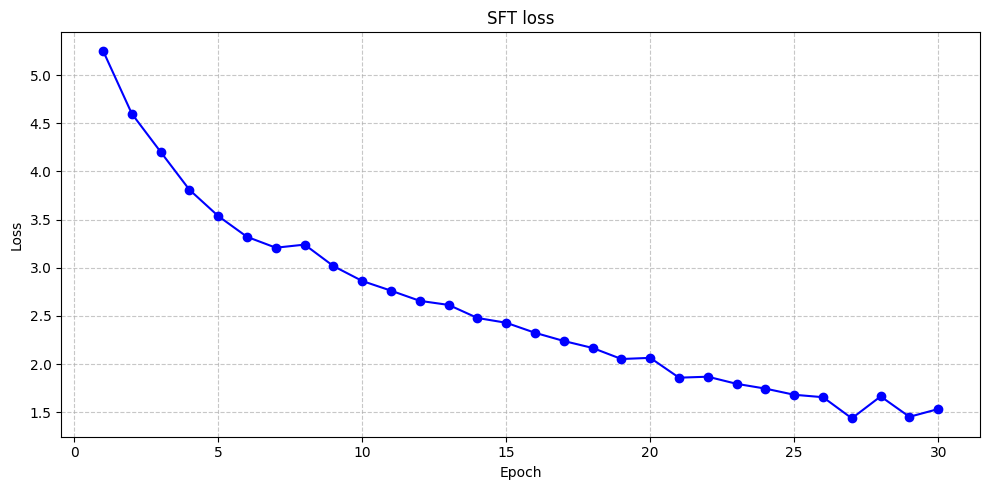

In [26]:
import matplotlib.pyplot as plt

# 绘制训练损失曲线
plt.figure(figsize=(10, 5))

# SFT 损失曲线
plt.plot(range(1, len(sft_losses)+1), sft_losses, marker='o', color='blue')
plt.title('SFT loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**预期结果**：SFT 阶段的损失应该呈现稳步下降趋势，表明模型正在学习指令与回答之间的关系。RM 阶段的损失也应该下降，表明奖励模型学会了区分好回答和差回答。PPO 阶段的平均奖励应该上升，表明模型生成的回答越来越符合奖励模型定义的"好"标准。

### 5.2 模型效果对比

我们可以对比 SFT 阶段和 PPO 阶段模型的生成效果：

In [27]:
# 生成函数（贪心/采样简化版）
@torch.no_grad()
def generate_text(model, tokenizer, prompt: str, max_new_tokens=32):
    pack = tokenizer.encode_dialog(prompt, "")
    input_ids = pack["input_ids"].unsqueeze(0).to(device)
    attn_mask = pack["attention_mask"].unsqueeze(0).to(device)

    # 去掉右侧 PAD
    true_len = int(attn_mask.sum(dim=1).item())
    input_ids = input_ids[:, :true_len]
    attn_mask = attn_mask[:, :true_len]

    for _ in range(max_new_tokens):
        logits = model(input_ids, attention_mask=attn_mask)
        next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
        input_ids = torch.cat([input_ids, next_token], dim=1)
        attn_mask = torch.cat([attn_mask, torch.ones_like(next_token)], dim=1)
        if next_token.item() == tokenizer.EOS:
            break

    # decode：去掉 BOS/SEP/EOS，只取回答区间
    ids = input_ids[0].tolist()
    if tokenizer.SEP in ids:
        sep_idx = ids.index(tokenizer.SEP)
        ans_ids = ids[sep_idx+1:]
    else:
        ans_ids = ids
    # 去掉 PAD 和 EOS
    ans_ids = [i for i in ans_ids if i not in (tokenizer.PAD, tokenizer.EOS)]
    # 减 4 还原字节
    text = bytes([i-4 for i in ans_ids]).decode("utf-8", errors="ignore")
    return text


In [28]:
# 模型效果对比
test_prompts = [
    "Write a greeting"
]

print("=== SFT 模型回答 ===")
for p in test_prompts:
    ans = generate_text(model, tokenizer, p)
    print(f"Q: {p}\nA: {ans}\n")

print("=== PPO 优化后策略回答 ===")
for p in test_prompts:
    ans = generate_text(policy, tokenizer, p)
    print(f"Q: {p}\nA: {ans}\n")


=== SFT 模型回答 ===
Q: Write a greeting
A: llololollinint te togy te t tet

=== PPO 优化后策略回答 ===
Q: Write a greeting
A: 



经过 PPO 优化的模型生成的回答应该比仅经过 SFT 的模型更符合人类偏好。

## 6. 总结与思考

本实验通过简化实现复现了 InstructGPT 的 RLHF 三阶段流程。虽然实际应用中的实现更加复杂，但核心思想是一致的：

1. **监督微调**为模型提供基础的指令跟随能力
2. **奖励模型**学习人类偏好并提供量化反馈
3. **PPO 强化学习**利用奖励信号进一步优化模型

这种方法的优势在于能够将人类的主观偏好有效地传递给模型，使模型生成更加符合人类期望的内容。